# Project Code Master
## Definitions
In this cell we define the key functions which are used for this sequence of code. These are explained in turn.

### `sample_spherical(npoints, ndim=3)`
Draw a set of 3 points from the normal distribution as a vector in $x$, $y$ and $z$, then normalise the vector to have unit length.

### `doppler_shift(angFreq,obsAngle,obsSpeed)`
Given the angular frequency of the source, the angle from the observer to the source (in the source rest frame) and the speed of the observer with respect to the stationary source, determine the Doppler shift of the angular frequency. This makes use of the relation $$\omega_0' = \omega_0 \frac{v \cos \alpha + 1}{\sqrt{1 - v^2}}.$$

### `ang_freq_to_lambda(omega)`
Convert angular frequency $\omega$ to wavelength $\lambda$.

### `lambda_to_ang_freq(wavelength)`
Convert wavelength $\lambda$ to angular frequency $\omega$.

### `vectors_angle(v1,v2)`
Given two vectors $v_1$ and $v_2$, determine the angle between them.

### `abberation_angle(angle,obsSpeed)`
Given an angle to a source $\alpha$, determine the angle $\alpha'$ perceived in the frame of an observer due to their relativistic movement with respect to the source. This makes use of the relation $$\cos \alpha' = \frac{v + \cos \alpha}{v \cos \alpha + 1}.$$

### `vectors_angle(v1,v2)`
Given two vectors $v_1$ and $v_2$, determine the unit normal vector to those two vectors, as given by their cross product $v_1 \times v_2$.

### `rotateMatrix(axis,angle)`
Determine the rotation matrix for rotating about an arbitrary axis by a given angle.

### `wavelength_to_rgb(wavelength, gamma=0.8)`
Convert a wavelength in nm to an RGB tuple, where each element is between 0 and 255.

### `determineAngleToObs(obsVector, xi, yi, zi)`
Given a vector of the observer's motion in Cartesian coordinates $(x,y,z)$ and a list of points defined through $(x_i,y_i,z_i)$, return an array giving the angle between the observer vector and the $i$-th point. Essentially just `vectors_angle` (uses this function) but gives array instead?

### `restLambdaToObsLambda(restLambda, angles, obsSpeed)`
Given a source (rest) wavelength, observer speed and angle between the observer's velocity vector and the source in the source rest frame calculate the perceived Doppler shifted wavelength. Uses `lambda_to_ang_freq`, followed by `doppler_shift`, followed by `ang_freq_to_lambda`.

### `wavelengthToRGB(obsLamda)`
Idk this makes it a numpy array or something unlike `wavelength_to_rgb`, which this function uses.

### `updatePoints(angles, obsSpeed, obsVector, xi, yi, zi)`
Given a set of points $(x_i,y_i,z_i)$, as well as an observer velocity vector, speed and set of angles between the observer vector and points, create a new set of points which are the abberated versions of $(x_i,y_i,z_i)$.

### `transformedPoints(obsSpeed,obsVector,restLambda,xi,yi,zi)`
The main sequence of steps required to return a tuple (`rotatedPoints`, `RBGs`, `obsLambda`), referring to the source points as perceived by an observer as well their corresponding RGBs based on their Doppler shifted wavelength, and the Doppler shifted wavelength itself.
- Determine the angles between the source points and the observer vector in the source frame using `determineAngleToObs`.
- Determine Doppler shifted wavelength using `restLambdaToObsLambda`.
- Convert wavelength to corresponding RGBs using `wavelengthToRGB`.
- Determine new set of points corresponding to the sources as perceived by the observer i.e. the abberated points.

### `cart2sph(obsVector)`
Cartesian to spherical coordinates.

### `sph2cart(obsPolar)`
Spherical to Cartesian coordinates given unit sphere.

In [1]:
import healpy as hp
%matplotlib widget

import numpy as np
from numpy import cross, eye, dot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import time
import math
import scipy.constants as sc
from scipy.linalg import expm, norm
import pandas
from matplotlib.widgets import Slider, Button
import colorcet as cc
import numba as nb
from astropy.coordinates import SkyCoord
import matplotlib.cm as cm

# Three variables drawn from Gaussian distribution
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

# Doppler shift a given angular frequency given angle to observer in source frame and observer's speed 
def doppler_shift(angFreq,obsAngle,obsSpeed):
    # obsAngFreq = angFreq*((np.sqrt(1-obsSpeed**2)/(1 - obsSpeed*np.cos(obsAngle)))) #old function—used wrong equation
    obsAngFreq = angFreq*((obsSpeed*np.cos(obsAngle)+1)/np.sqrt(1-obsSpeed**2))
    return obsAngFreq

def ang_freq_to_lambda(omega):
    wavelength = sc.c/(2*math.pi*omega)
    return wavelength

def lambda_to_ang_freq(wavelength):
    omega = sc.c/(2*math.pi*wavelength)
    return omega

def vectors_angle(v1, v2):
    if (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) <= 1 and (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) >= -1:
        return math.acos((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    elif (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) < -1:
        print('Less:' + str((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))))
        return math.acos(-1)
    elif (np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)) > 1:
        print('Greater:' + str((np.dot(v1, v2))/(np.linalg.norm(v1)*np.linalg.norm(v2))))
        return math.acos(1)

# def vectors_angle(v1,v2):
#     angle = math.acos((np.dot(v1,v2))/(np.linalg.norm(v1)*np.linalg.norm(v2)))
#     return angle

def abberation_angle(angle,obsSpeed):
    abberationAngle = np.arccos((obsSpeed + np.cos(angle))/(obsSpeed*np.cos(angle)+1)) # changed from math.acos to np trig
    return abberationAngle

def unit_norm_vector(v1,v2):
    normVector = np.cross(v1,v2)
    unitNormVector = normVector/np.linalg.norm(normVector)
    return unitNormVector

def rotateMatrix(axis,angle):
    rotatedMatrix = expm(cross(eye(3), axis/norm(axis)*angle))
    return rotatedMatrix

def wavelength_to_rgb(wavelength, gamma=0.8):
    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return [int(R), int(G), int(B)]

def determineAngleToObs(obsVector, xi, yi, zi):
    # angles between all vectors and observer vector from dot product
    angles = []
    for i in range(0, len(xi)):
        angles.append(vectors_angle(obsVector, (xi[i], yi[i], zi[i])))
    return angles

# NEW ANGLE FUNCTION
#You can disable parallelization with parallel=False
@nb.njit(fastmath=True,error_model="numpy",parallel=False)
def angle(v1,v2):
    #Check the dimensions, this may also have an effect on SIMD-vectorization
    assert v1.shape[1]==3
    assert v2.shape[1]==3
    res=np.empty(v1.shape[0])

    for i in nb.prange(v1.shape[0]): #v2 is now the observer vector
        dot=0.
        a=0.
        b=0.
        for j in range(3):
            dot+=v1[i,j]*v2[0,j]
            a+=v1[i,j]**2
            b+=v2[0,j]**2
        res[i]=np.arccos(dot/(np.sqrt(a*b)))
        # for j in range(3):
        #     dot+=v1[i,j]*v2[i,j]
        #     a+=v1[i,j]**2
        #     b+=v2[i,j]**2
        # res[i]=np.arccos(dot/(np.sqrt(a*b)))
    return res

def restLambdaToObsLambda(restLambda, angles, obsSpeed):
    # lambda values as perceived by moving observer
    restAngFreq = lambda_to_ang_freq(restLambda) # fine
    obsLambda = (ang_freq_to_lambda(doppler_shift(restAngFreq, angles, obsSpeed))) # probably slow
    print('Found obsLamda')
    return obsLambda

def wavelengthToRGB(obsLambda):
    RGBs = []
    for i in range(0, len(obsLambda)):
        RGBs.append(wavelength_to_rgb(obsLambda[i]))
    RGBs = np.asarray(RGBs, dtype=np.float32)
    return RGBs

def updatePoints(angles, obsSpeed, obsVector, xi, yi, zi):
    ## Now we try to congregate points along the source of motion due to abberation
    # angle difference
    print('Updating points')
    rotatedPoints = np.zeros((len(xi),3))
    deltaAngles = -(abberation_angle(angles, obsSpeed) - angles)
    rotAxes = unit_norm_vector(np.asarray((xi,yi,zi)).T,obsVector) # turn points xi, yi, zi to array
    for i in range(0, len(rotatedPoints)):
        # print(i)
        # deltaAngles = -(abberation_angle(angles[i], obsSpeed) - angles[i])
        # print('here 1')
        # rotAxes = unit_norm_vector((xi[i], yi[i], zi[i]), obsVector)
        # print('here 2')
        rotationMatrices = rotateMatrix(rotAxes[i],deltaAngles[i])
        # print('here 3')
        rotatedPoints[i] = dot(rotationMatrices,(xi[i], yi[i], zi[i]))
        # print('here 4')
    rotatedPoints = np.asarray(rotatedPoints, dtype=np.float32)
    return rotatedPoints

    # deltaAngles = []
    # for i in range(0, len(angles)):
    #     deltaAngles.append(-(abberation_angle(angles[i], obsSpeed) - angles[i]))
    # # normal vector/rotation axes
    # rotAxes = []
    # for i in range(0, len(angles)):
    #     rotAxes.append(unit_norm_vector((xi[i], yi[i], zi[i]), obsVector))
    # rotationMatrices = []
    # for i in range(0, len(rotAxes)):
    #     rotationMatrices.append(rotateMatrix(rotAxes[i], deltaAngles[i]))
    # rotatedPoints = []
    # for i in range(0, len(rotationMatrices)):
    #     rotatedPoints.append(dot(rotationMatrices[i], (xi[i], yi[i], zi[i])))
    # rotatedPoints = np.asarray(rotatedPoints, dtype=np.float32)
    # print('Points updated')
    # return rotatedPoints

def transformedPoints(obsSpeed,obsVector,restLambda,initialPointsVectors):
    angles = angle(initialPointsVectors,obsVector) # fine
    # angles = determineAngleToObs(obsVector,xi,yi,zi)
    obsLambda = restLambdaToObsLambda(restLambda,angles,obsSpeed)*10**9 # possibly slow
    RGBs = wavelengthToRGB(obsLambda)
    shift = ((obsLambda*10**(-9) - restLambda)/restLambda)
    # changed from xi, yi, zi to initial point vectors
    rotatedPoints = updatePoints(
        angles, obsSpeed, obsVector, initialPointsVectors[:, 0],
        initialPointsVectors[:, 1], initialPointsVectors[:, 2])
    return rotatedPoints, shift, obsLambda

def cart2sph(obsVector):
    hxy = np.hypot(obsVector[0],obsVector[1])
    if obsVector[2] == 0:
        theta = np.pi/2
    else:
        theta = np.arccos(obsVector[2]/math.sqrt(obsVector[0]**2 + obsVector[1]**2 + obsVector[2]**2))
    if obsVector[0] > 0:
        atan = np.arctan(obsVector[1]/obsVector[0])
        phi = atan
    elif obsVector[0] < 0 and obsVector[1] >= 0:
        atan = np.arctan(obsVector[1]/obsVector[0])
        phi = atan + np.pi
    elif obsVector[0] < 0 and obsVector[1] < 0:
        atan = np.arctan(obsVector[1]/obsVector[0])
        phi = atan - np.pi
    elif obsVector[0]==0 and obsVector[1] > 0:
        phi = np.pi/2
    elif obsVector[0]==0 and obsVector[1] < 0:
        phi = -np.pi/2
    elif obsVector[0] == 0 and obsVector[1] == 0:
        phi = 0
    return (theta, phi)

def sph2cart(obsPolar): #r=1
    x = np.sin(obsPolar[0]) * np.cos(obsPolar[1])
    y = np.sin(obsPolar[0]) * np.sin(obsPolar[1])
    z = np.cos(obsPolar[0])
    return (x, y, z)

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def pixelAverage(nside,):
    npix = hp.nside2npix(nside) # number of pixels
    ordered_pixels = np.arange(npix) # ordered vector of pixel numbers
    pixel_indices = hp.vec2pix(nside, rotatedPoints[0:len(rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(
        rotatedPoints), 2])  # Gives me the pixel number corresponding to that particular data vector

    # find repeated pixel indices (more than one point in a pixel), and average over
    idx_sort = np.argsort(pixel_indices) # creates an array of indices, sorted by unique element
    sorted_pixel_indices = pixel_indices[idx_sort] # sorts records array so all unique elements are together 

    vals, idx_start, count = np.unique(
        sorted_pixel_indices, return_counts=True, return_index=True) # returns the unique values, the index of the first occurrence of a value, and the count for each element
    res = np.split(idx_sort, idx_start[1:]) # splits the indices into separate arrays

    #filter them with respect to their size, keeping only items occurring more than once
    vals = vals[count > 1]
    res = filter(lambda x: x.size > 1, res)
    vals # actual values of the repeated index
    repeated_indices = tuple(res) # tuple containing the indices of each repeated pixel index in pixel_indices (length n) 

    # Source density map
    idx, counts = np.unique(pixel_indices, return_counts=True)
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    ###

    # returns average value of tau for pixels where the index is repeated, then replaces tau value for repeated pixels with average
    print('Averaging over pixels')
    tau_averages = []
    tau_new_uncertainties = []
    for i in range(0,len(repeated_indices)):
        taus = []
        tau_unc = []
        for j in range(0,len(repeated_indices[i])):
            taus.append(tau_new[repeated_indices[i][j]])
            tau_unc.append(tau_uncertainties[repeated_indices[i][j]])
        tau_averages.append(np.mean(taus))
        tau_new_uncertainties.append(
            1/(len(tau_unc))*np.sqrt(np.sum(np.asarray(tau_unc)**2)))
        tau_new[repeated_indices[i]] = tau_averages[i] # replace corresponding tau_new for repeated pixels with the average tau
        # replace corresponding tau_uncertainties for repeated pixels with the errors added in quadrature
        tau_uncertainties[repeated_indices[i]] = tau_new_uncertainties[i]

    m = np.zeros(hp.nside2npix(nside)) # zero vector of length number of pixels on the sky
    a = np.zeros(hp.nside2npix(nside)) # zero vector of length number of pixels on the sky
    m[pixel_indices] = tau_new # match the pixel number of point x_i, y_i, z_i to the corresponding dilated time-scale
    a[pixel_indices] = tau_uncertainties # uncertainties of each pixel

    # create vectors corresponding to location of pixel on the sky
    x_pix, y_pix, z_pix = hp.pix2vec(nside,ordered_pixels)
    pixelVectors = np.asarray([x_pix,y_pix,z_pix]).T # turn into nested array

    return pixelVectors, m, a, hpx_map

    from astropy.coordinates import SkyCoord

# https://stackoverflow.com/questions/50483279/make-a-2d-histogram-with-healpix-pixellization-using-healpy
def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates

    """

    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map


## Number of Points Needed
With the functions loaded, first we draw the points for a given $n$ from the spherical distribution, find the transformed (rotated) points due to the observer's actual motion and then bin into pixels. Then we fit parameters. Finally, we take the evidences for the null hypothesis, the fitted hypothesis and the CMB hypothesis, and repeat this twice, finding the average for each. This is repeated for a different number of pixels.

0
Sampling points, n = 5000000
Rotating points non-masked
Found obsLamda
Updating points
1.5080164867544654
0.44059301277316487
Creating pixels, nside = 16
Averaging over pixels


18596it [00:44, 420.19it/s, batch: 8 | bound: 51 | nc: 2 | ncall: 53504 | eff(%): 34.756 | loglstar: 7065.939 < 7072.253 < 7071.832 | logz: 7063.764 +/-  0.159 | stop:  0.954]     


FileNotFoundError: [Errno 2] No such file or directory: '27-06/0-corner-tau-n5000000-nside16.pdf'

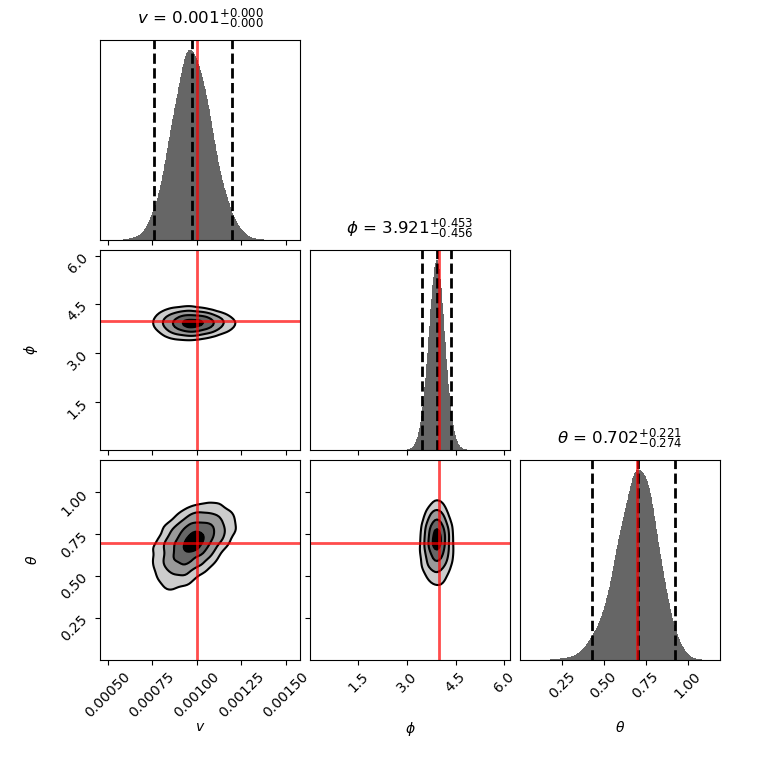

In [2]:
# print('Initialising plot')
# # ax.set_box_aspect((1,1,1))
# fig, ax = plt.subplots(
#     1, 1, subplot_kw={'projection': '3d', 'aspect': 'auto'})
# scat = ax.scatter(maskedPoints[:, 0], maskedPoints[:, 1],
#                   maskedPoints[:, 2], s=10,  zorder=10)

# initial variables
import scipy.stats as sts
import healpy as hp
import dynesty
from dynesty import plotting as dyplot
import multiprocess

restLambda = ang_freq_to_lambda(1)  # define ang_freq to be 1.
obsSpeed = 0.001
# obsVector = (1, 1, 1)
obsPolar = (0.7, 4) # pol, az
observerVector = sph2cart(obsPolar)
observerVector2 = np.asarray([observerVector])
pol_true, az_true = obsPolar
v_true = obsSpeed

def model(v, az, pol):
    observerVector = sph2cart((pol, az))
    observerVector2 = np.asarray([observerVector])
    alphaDash = angle(pixelVectors, observerVector2)
    # alphaDash = determineAngleToObs(observerVector,x_pix,y_pix,z_pix) # OLD function; find what the Doppler shift should be at the pixel location (presumably the centre of the pixel)
    model = tau_true_pixels * \
        (1-v*np.cos(alphaDash))/(np.sqrt(1-v**2)
                                    )  # assumes knowledge of actual time-scale
    return model

def prior_transform(uTheta):
    uV, uAz, uPol = uTheta
    v = 0.01*uV  # uniform between 0 and 0.01
    az = 2*np.pi*uAz  # uniform between 0 and 2*pi # np.pi + np.pi*uAz
    pol = uPol*np.pi  # uniform between 0 and pi
    return v, az, pol

def lnlike(Theta):
    v, az, pol = Theta
    # turn az and pol into alpha' for this omega
    tau_val = model(v, az, pol)
    # changed tau_new to m, tau_uncertainties to a
    return sum(sts.norm.logpdf(m_new, loc=tau_val, scale=a_new))

# main loop
trial = 0
for trial in range(0,1):
    print(trial)
    for n in [5*10**6]:#,10**6,5*10**6,10**7]:
        # sample points from spherical distribution
        print('Sampling points, n = ' + str(n))
        xi, yi, zi = sample_spherical(n)
        initialPointsVectors = np.asarray([xi, yi, zi]).T

        # print('Masking points')
        # theta = np.zeros(len(initialPointsVectors))
        # for i in range(0, len(initialPointsVectors)):
        #     theta[i] = np.arccos(initialPointsVectors[i, 2]/math.sqrt(initialPointsVectors[i, 0]
        #         ** 2 + initialPointsVectors[i, 1]**2 + initialPointsVectors[i, 2]**2))
        # maskedPoints = initialPointsVectors[(
        #     theta <= np.deg2rad(60)) | (theta >= np.deg2rad(120))] # changed from < and > 

        print('Rotating points non-masked')
        rotatedPoints, RGBs, obsLambda = transformedPoints(
            obsSpeed,observerVector2,restLambda,initialPointsVectors)

        # # # ax.set_box_aspect((1,1,1))
        # fig, ax = plt.subplots(
        #     1, 1, subplot_kw={'projection': '3d', 'aspect': 'auto'})
        # scat = ax.scatter(initialPointsVectors[:, 0], initialPointsVectors[:, 1],
        #           initialPointsVectors[:, 2], s=10,  zorder=10)

        # print('Rotating points masked')
        # rotatedPoints, RGBs, obsLambda = transformedPoints(
        #     obsSpeed, observerVector2, restLambda, maskedPoints)

        # fig, ax = plt.subplots(
        #     1, 1, subplot_kw={'projection': '3d', 'aspect': 'auto'})
        # ax.set_box_aspect((np.ptp(xi), np.ptp(yi), np.ptp(zi)))
        # scat = ax.scatter(maskedPoints[:, 0], maskedPoints[:, 1],
        #                   maskedPoints[:, 2], s=10,  zorder=10)

        # create DRW time-scales on the sky
        sigma = 0.1
        tau_true = np.ones(len(rotatedPoints)) # rest frame tau values (unity for all points) 
        rotatedPointVectors = np.asarray([rotatedPoints[0:len(
            rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2]]).T  # as above
        alphaDash = angle(rotatedPointVectors, observerVector2)
        tau_dilated = tau_true * \
            (1-obsSpeed*np.cos(alphaDash))/(np.sqrt(1-obsSpeed**2)) # time-dilated taus

        fitted_evidence = []
        fitted_evidence_unc = []
        null_evidence = []
        cmb_evidence = []
        # bin points into pixels and average of pixel
        for nside in [16]:#,8,16,32]:
            #add measurement uncertainty
            np.random.seed(141)
            tau_error = np.random.normal(loc=0, scale=sigma, size=len(tau_true))
            tau_new = tau_dilated + tau_error  # actual measured time-scales in observer frame
            observed_data = tau_new
            print(max(tau_new))
            print(min(tau_new))
            tau_uncertainties = 0.1*np.ones(len(tau_new)) # uncertainty assumed to be 10%
            
            print('Creating pixels, nside = ' + str(nside))
            
            npix = hp.nside2npix(nside)  # number of pixels
            pixelVectors, m, a, hpx_map = pixelAverage(nside)

            ### NEW masking after averaging ###
            theta = np.zeros(len(pixelVectors))
            for i in range(0, len(pixelVectors)):
                theta[i] = np.arccos(pixelVectors[i, 2]/math.sqrt(pixelVectors[i, 0]
                    ** 2 + pixelVectors[i, 1]**2 + pixelVectors[i, 2]**2))
            # pixelVectors[(
                # theta <= np.deg2rad(60)) | (theta >= np.deg2rad(120))] = 0
            
            # set to 0 where inside mask
            m[
                (theta >= np.deg2rad(60)) & (theta <= np.deg2rad(120))] = 0
            a[
                (theta >= np.deg2rad(60)) & (theta <= np.deg2rad(120))] = 0
            
            # remove masked pixels which have tau = 0 for model fitting
            a_new = a[m!=0]
            m_new = m[m!=0]
            pixelVectors = pixelVectors[np.where(m!= 0)]
            tau_true_pixels = np.ones(npix)
            tau_true_pixels = tau_true_pixels[
                np.where(m!= 0)]
            
            # fit parameters
            with multiprocess.Pool(8) as pool:
                dsampler = dynesty.DynamicNestedSampler(
                    lnlike, prior_transform, ndim=3, pool=pool, queue_size=8)
                dsampler.run_nested()
                dresults = dsampler.results

            # plot and save cornerplot
            fig, axes = dyplot.cornerplot(dresults,
                truths=[v_true,az_true,pol_true],
                show_titles=True,
                title_kwargs={'y': 1.04},
                labels=['$v$','$\phi$','$\\theta$'],
                title_fmt='.3f')
            
            plt.savefig('27-06/' + str(trial) +  '-corner-tau-n' + str(n) + '-nside' + str(nside) + '.pdf')
            print('Corner plot saved')

            # Evidences
            ## fitted
            lnZ = dresults.logz[-1]
            lnZ_err = dresults.logzerr[-1]
            fitted_evidence.append(lnZ)
            fitted_evidence_unc.append(lnZ_err)
            print("log(Z) = {0:1.4f} ± {1:1.4}".format(lnZ, lnZ_err))

            ## null
            tau_val_null = 1
            log_Z_0 = sum(sts.norm.logpdf(m_new, loc=tau_val_null, scale=a_new))
            null_evidence.append(log_Z_0)
            print("log(Z_0) = {0:1.1f}".format(log_Z_0))

            ### CMB motion
            pol, az, v = np.pi/2 - (48.253*np.pi/180), 246.021 * \
                np.pi/180, (369.82*1000)/sc.c
            # pol = np.pi - pol
            # az = np.pi + az
            CMBDipoleVector = sph2cart((pol, az))
            CMBDipoleVector2 = np.asarray([CMBDipoleVector])
            alphaDash_CMB = angle(pixelVectors, CMBDipoleVector2)
            tau_val_CMB = tau_true_pixels * \
                (1-v*np.cos(alphaDash_CMB))/(np.sqrt(1-v**2))
            log_Z_CMB = sum(sts.norm.logpdf(m_new, loc=tau_val_CMB, scale=a_new))
            cmb_evidence.append(log_Z_CMB)
            print("log(Z_CMB) = {0:1.1f}".format(log_Z_CMB))

        # print(trial)
        # dump evidence values to csv
        # np.savetxt(
        #     '13-06/' +  str(trial) + '-fitted-' + 'n-' + str(n) + '.csv', fitted_evidence, delimiter=",")
        # np.savetxt(
        #     '13-06/' +  str(trial) + '-null-' + 'n-' + str(n) + '.csv', null_evidence, delimiter=",")
        # np.savetxt(
        #     '13-06/' + str(trial) + '-cmb-' + 'n-' + str(n) + '.csv', cmb_evidence, delimiter=",")
        # np.savetxt(
        #     '13-06/' + str(trial) + '-fitted_unc-' + 'n-' + str(n) + '.csv', fitted_evidence_unc, delimiter=",")
        # print('Evidences saved')


In [3]:
%store dresults m hpx_map

Stored 'dresults' (Results)
Stored 'm' (ndarray)
Stored 'hpx_map' (ndarray)


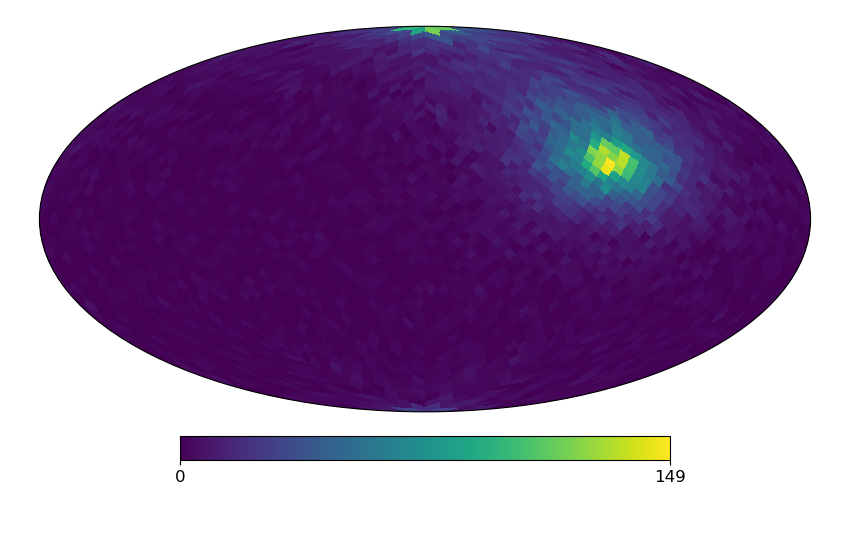

In [4]:
# pixel_indices = hp.ang2pix(nside,dresults.samples[:,2],dresults.samples[:,1]) # theta, phi

# plt.subplot(projection='hammer')

# plt.figure()

npix = hp.nside2npix(nside)

cart_vecs = sph2cart((dresults.samples[:,2],dresults.samples[:,1]))

pixel_indices = hp.vec2pix(nside,cart_vecs[0],cart_vecs[1],cart_vecs[2])

idx, counts = np.unique(pixel_indices, return_counts=True)

hpx_map = np.zeros(npix, dtype=int)
hpx_map[idx] = counts

# hpx_map = cat2hpx(np.rad2deg(dresults.samples[:, 1]),
                #   np.rad2deg(dresults.samples[:, 2]), nside, radec=False)

hp.projview(hpx_map,projection_type='hammer')

hp.graticule(color='white')

# plt.hist2d(dresults.samples[:,1],dresults.samples[:,2],bins=200)

# hist, lon_edges, lat_edges = np.histogram2d(dresults.samples[:,1],dresults.samples[:,2],bins=200)

# cmap = plt.cm.viridis

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='hammer')

# ax.pcolor(
#     lon_edges[:-1], lat_edges[:-1],
#     hist.T,  # transpose from (row, column) to (x, y)
#     cmap=cmap, shading='auto',
#     vmin=0, vmax=1
# )

# plt.imshow(hist, interpolation='nearest', origin='lower',
#            extent=[lon_edges[0], lon_edges[-1], lat_edges[0], lat_edges[-1]])
# plt.show()

# # creates an array of indices, sorted by unique element
# idx_sort = np.argsort(pixel_indices)
# # sorts records array so all unique elements are together
# sorted_pixel_indices = pixel_indices[idx_sort]

# vals, idx_start, count = np.unique(
#     sorted_pixel_indices, return_counts=True, return_index=True)  # returns the unique values, the index of the first occurrence of a value, and the count for each element
# # splits the indices into separate arrays
# res = np.split(idx_sort, idx_start[1:])

# #filter them with respect to their size, keeping only items occurring more than once
# vals = vals[count > 1]
# res = filter(lambda x: x.size > 1, res)
# vals  # actual values of the repeated index
# # tuple containing the indices of each repeated pixel index in pixel_indices (length n)
# repeated_indices = tuple(res)

# dresults.samples[:,0]

# dyplot.cornerpoints(dresults)

In [9]:
# m_new = m[np.where(pixelVectors[(
    # theta <= np.deg2rad(60)) | (theta >= np.deg2rad(120))])]

m_new = m[(theta <= np.deg2rad(60)) | (theta >= np.deg2rad(120))]



In [ ]:
plt.figure()
plt.hist(m,bins=30)
plt.hist(m_resampled,bins=30,alpha=0.5)
plt.show()


## Data Analysis

In [ ]:
log_Z_0 = sum(sts.norm.logpdf(m, loc=tau_val_null, scale=a)) # nside 32, n = 10**7
# m contains observed time-scale tau of ith pixel; a contains uncertainty of ith pixel
print('Sampled log_Z0: ' + str(log_Z_0.round(1)))

for n in range(0, 11):
    np.random.seed()
    resampled_m = m + np.random.normal(loc=0,scale=a,size=len(m))
    log_Z_0_resampled = sum(sts.norm.logpdf(resampled_m, loc=tau_val_null, scale=a)) # loc at the theoretical value—in this case the null hypothesis
    
    print('Resampled log_Z0: ' + str(log_Z_0_resampled.round(1)))

print(m)
print(a)
print(resampled_m)
plt.figure()
plt.hist(m,bins=30)
plt.hist(resampled_m,bins=30,alpha=0.5)
plt.show()

## Loading data (different points)

In [ ]:
import pandas as pd
import csv
import numpy as np
import healpy as hp

cmb_matrix = np.zeros((4,4))
results = []
for n in [500000,1000000,5000000,10000000]:
    with open('23-05-v3/cmb-n-' + str(n) + '.csv') as csvfile:
        # change contents to floats
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader: # each row is a list
            results.append(row)

res = np.array_split(results, 4)
data = np.column_stack((res[0], res[1], res[2], res[3]))
df_cmb = pd.DataFrame(data, columns=['n500000', 'n1000000', 'n5000000', 'n10000000'], index=[
                  'nside4', 'nside8', 'nside16', 'nside32'])

fitted_matrix = np.zeros((4, 4))
results = []
for n in [500000, 1000000, 5000000, 10000000]:
    with open('23-05-v3/fitted-n-' + str(n) + '.csv') as csvfile:
        # change contents to floats
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:  # each row is a list
            results.append(row)

res = np.array_split(results, 4)
data = np.column_stack((res[0], res[1], res[2], res[3]))
df_fitted = pd.DataFrame(data, columns=['n500000', 'n1000000', 'n5000000', 'n10000000'], index=[
    'nside4', 'nside8', 'nside16', 'nside32'])

null_matrix = np.zeros((4, 4))
results = []
for n in [500000, 1000000, 5000000, 10000000]:
    with open('23-05-v3/null-n-' + str(n) + '.csv') as csvfile:
        # change contents to floats
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:  # each row is a list
            results.append(row)

res = np.array_split(results, 4)
data = np.column_stack((res[0], res[1], res[2], res[3]))
df_null = pd.DataFrame(data, columns=['n500000', 'n1000000', 'n5000000', 'n10000000'], index=[
    'nside4', 'nside8', 'nside16', 'nside32'])

print('Fitted hypothesis')
display(df_fitted.round(1))

print('CMB hypothesis')
display(df_cmb.round(1))

print('Null hypothesis')
display(df_null.round(1))

print('Bayes factor')
display((df_fitted - df_cmb).round(1))

print('nside4 = ' + str(hp.nside2npix(4)) + ' pixels, ' +
      'nside8 = ' + str(hp.nside2npix(8)) + ' pixels, ' +
      'nside16 = ' + str(hp.nside2npix(16)) + ' pixels, ' +
      'nside32 = ' + str(hp.nside2npix(32)) + ' pixels')


# df


### Estimating error
- Average of evidence across trials.
- $1 \sigma$ for error.
- Then determine the Bayes factors with averages?

In [ ]:
import pandas as pd
import csv
import numpy as np
import healpy as hp

len_trials = 6

results_cmb = []
for i in range(0,len_trials):
    with open('13-06/' + str(i) + '-cmb' '-n-' + str(n) + '.csv') as csvfile:
        # change contents to floats
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader: # each row is a list
            results_cmb.append(row)

av_cmb = np.average(results_cmb)
unc_cmb = np.std(results_cmb)

results_fitted = []
for i in range(0,len_trials):
    with open('13-06/' + str(i) + '-fitted' '-n-' + str(n) + '.csv') as csvfile:
        # change contents to floats
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader: # each row is a list
            results_fitted.append(row)

av_fitted = np.average(results_fitted)
unc_fitted = np.std(results_fitted)

results_null = []
for i in range(0, len_trials):
    with open('13-06/' + str(i) + '-null' '-n-' + str(n) + '.csv') as csvfile:
        # change contents to floats
        reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:  # each row is a list
            results_null.append(row)

av_null = np.average(results_null)
unc_null = np.std(results_null)


df = pd.DataFrame(index=['trial0','trial1', 'trial2', 'trail3', 'trial4', 'trial5'], columns=['null','± null','cmb','± cmb','fitted','± fitted'])
df.loc[:, 'null'] = results_null[0::2]
df['null'] = df['null'].str[0] # convert out of list
df.loc[:,'± null'] = unc_null

df.loc[:,'cmb'] = results_cmb
df.loc[:,'± cmb'] = unc_cmb

df.loc[:,'fitted'] = results_fitted
df.loc[:,'± fitted'] = unc_fitted

display(df.round(2))

# print(all_results)

# res = np.array_split(results, 5)
# data = np.column_stack((res[0], res[1], res[2], res[3],res[4]))
# df_cmb = pd.DataFrame(data, columns=['trial1', 'trial2', 'trail3', 'trial4', 'trial5'], index=[
#                   'nside4', 'nside8', 'nside16', 'nside32'])

# av Bayes factors
print('Log Bayes factor fitted/null: ' + str(av_fitted - av_null))
print('Log Bayes factor fitted/cmb: ' + str(av_fitted - av_cmb))




In [ ]:
(1/6)*np.sqrt(6*(unc_null)**2)

In [ ]:
import os
os.makedirs('test', exist_ok=True)  
df_null.to_csv('test/null-evidences.csv')

## Points on Sphere Plot

### Initiation
First we define a wavelength of the source emitted in its rest frame `restLambda`, then a speed of the observer `obsSpeed` with respect to the source and a direction vector $(x,y,z)$ for the observer's motion. This is transformed into polar coordinates (`obsPolar`) via `cart2sph(obsVector)`.

Next, we sample points $(x_i,y_i,z_i)$ using `sample_spherical`, and then transform them to the observer frame via `transformedPoints`. This yields a new set of points corresponding RGB values based on the perceived wavelength after Doppler shift. These points are then plotted on a 3D scatter graph.

### Manipulation
The speed of the observer, as well as the observer vector, can be changed through the speed slider and the azimuthal and polar sliders respectively.

/var/folders/f0/bpm69fqn0jl4w0k0w01_lftw0000gn/T/ipykernel_8074/1533310695.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


Sampling points from sphere
Rotating points
Found obsLamda
Updating points
Initialising plot


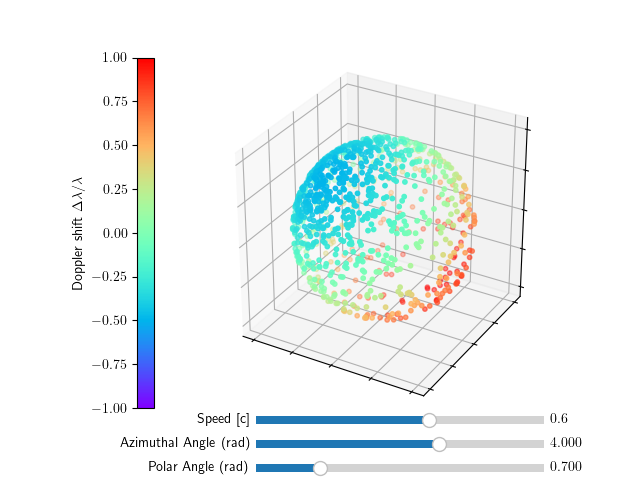

In [116]:
from matplotlib import rc
import matplotlib

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Times-Roman']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]

# import healpy as hp

# restLambda = 550*10**(-9)
restLambda = ang_freq_to_lambda(1) # define ang_freq to be 1.
obsSpeed = 0.6
# obsVector = (1, 1, 1)
obsPolar = (0.7,4)
observerVector = sph2cart(obsPolar)
observerVector2 = np.asarray([observerVector]) # plays nice with the new angle function
n = 10**3 # number of points to sample


print('Sampling points from sphere')
xi, yi, zi = sample_spherical(n)
initialPointsVectors = np.asarray([xi, yi, zi]).T

print('Rotating points')
rotatedPoints, shift, obsLambda = transformedPoints(
    obsSpeed,observerVector2,restLambda,initialPointsVectors)

obsAngFreq = lambda_to_ang_freq(obsLambda*10**(-9)) #list of Doppler shifted angular frequencies
normalisedObsAngFreq = NormalizeData(obsAngFreq)

# Create the figure and the line that we will manipulate
print('Initialising plot')
fig, ax = plt.subplots(
    1, 1, subplot_kw={'projection': '3d', 'aspect': 'auto'})
ax.set_box_aspect((np.ptp(xi), np.ptp(yi), np.ptp(zi)))
scat = ax.scatter(
    rotatedPoints[0:len(rotatedPoints),0],
    rotatedPoints[0:len(rotatedPoints),1],
    rotatedPoints[0:len(rotatedPoints),2],
    s=10,
    # c = RGBs/255.0,
    c = shift,
    cmap='rainbow',
    vmin=-1,
    vmax=1,
    zorder=10)

# plt.tight_layout()

cbar = plt.colorbar(scat,location='left')
cbar.set_label('Doppler shift $\Delta \lambda / \lambda$')
# scat = ax.scatter(rotatedPoints[0:len(rotatedPoints), 0], rotatedPoints[0:len(
#     rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2], s=10, zorder=10, c=normalisedObsAngFreq, cmap=cc.cm.rainbow_bgyr_10_90_c83_r)
# plt.title('Points as Perceived by Moving Observer, $n = {}$'.format(n))

# Remove tick labels from axes
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# adjust the main plot to make room for the sliders
# plt.subplots_adjust(left=0.25, bottom=0.25)
plt.subplots_adjust(bottom=0.15)

# Make a horizontal slider to control the speed of the observer.
axSpeed = plt.axes([0.4, 0.11, 0.45, 0.03])
speed_slider = Slider(
    ax=axSpeed,
    label='Speed [c]',
    valmin=0,
    valmax=0.9999999,
    valinit=obsSpeed,
)

axAzimuthal = plt.axes([0.4, 0.06, 0.45, 0.03])
azimuthal_slider = Slider(
    ax=axAzimuthal,
    label='Azimuthal Angle (rad)',
    valmin=0,
    valmax=(np.pi)*2,
    valinit=obsPolar[1],
)

axPolar = plt.axes([0.4, 0.01, 0.45, 0.03])
polar_slider = Slider(
    ax=axPolar,
    label='Polar Angle (rad)',
    valmin=0,
    valmax=np.pi,
    valinit=obsPolar[0],
)

# The function to be called anytime a slider's value changes
def update(val):
    obsPolar = (polar_slider.val,azimuthal_slider.val)
    rotatedPoints, shift, obsLambda = transformedPoints(speed_slider.val, np.asarray(
        [sph2cart(obsPolar)]), restLambda, initialPointsVectors)  # changed obsPolar so it plays nice
    scat._offsets3d = (
        rotatedPoints[0:len(rotatedPoints),0],
        rotatedPoints[0:len(rotatedPoints),1],
        rotatedPoints[0:len(rotatedPoints),2])
    # np.c_[RGBs, 255*np.ones(len(RGBs))] # add alpha channel—RGBA.
    # scat._facecolor3d = RGBs/255.0
    # scat._edgecolor3d = RGBs/255.0
    # scat.set_array(RGBs/255.0)
    # scat.set_color(RGBs/255.0)
    scat.set_array(shift)
    fig.canvas.draw()

speed_slider.on_changed(update)
azimuthal_slider.on_changed(update)
polar_slider.on_changed(update)

plt.show()

plt.savefig("Report Figures/points-on-sphere2.pdf",bbox_inches='tight')

In [43]:
rotatedPoints, shift, obsLambda = transformedPoints(speed_slider.val, np.asarray(
    [sph2cart(obsPolar)]), restLambda, initialPointsVectors) # changed obsPolar so it plays nice

# rotatedPoints, RGBs, obsLambda = transformedPoints(obsSpeed,observerVector2,restLambda,initialPointsVectors)
# print(np.asarray([sph2cart(obsPolar)]))
# print(observerVector2)

shift

Found obsLamda
Updating points


array([ 2.62256406e-04,  6.41128889e-04, -2.63420749e-04, -1.73030895e-04,
       -4.04059232e-05, -1.68692256e-05, -7.58862146e-04,  9.26712328e-04,
        6.34979401e-04, -2.69270899e-04, -8.65876829e-04,  2.86099807e-04,
       -1.64897800e-04, -6.31062238e-04,  7.65692222e-04, -2.55367107e-04,
        7.40552937e-04, -7.63971069e-04,  8.39666812e-04, -7.89092480e-04,
        7.10082791e-05, -2.29864692e-04, -5.00281572e-04, -6.79309812e-04,
        7.51626160e-04, -9.45200319e-04,  1.23581094e-04, -4.04962870e-04,
       -4.36938754e-04,  8.82212743e-04, -6.99517146e-04,  9.83743037e-04,
       -2.56068977e-04,  7.63825802e-04, -9.04958126e-04, -2.25699160e-04,
        6.73632995e-04,  5.86022081e-04, -6.91888076e-04, -5.89776402e-04,
       -9.76057573e-04,  3.87940325e-04, -2.13903344e-05, -7.20684557e-04,
       -6.98484604e-06, -4.06334951e-04,  6.53824609e-04,  3.43386685e-04,
        9.25132236e-04,  8.47205946e-04,  2.49761810e-04,  8.93829451e-04,
        5.39927924e-04,  

### Masking

In [ ]:
theta = np.zeros(len(initialPointsVectors))

for i in range(0,len(initialPointsVectors)):
    theta[i] = np.arccos(initialPointsVectors[i,2]/math.sqrt(initialPointsVectors[i,0]
        ** 2 + initialPointsVectors[i,1]**2 + initialPointsVectors[i,2]**2))

print(theta)

maskedPoints = initialPointsVectors[(theta < np.deg2rad(60)) | (theta > np.deg2rad(120))]


print(maskedPoints)
maskedPoints[:,0]

print('Initialising plot')
# ax.set_box_aspect((1,1,1))
fig, ax = plt.subplots(
    1, 1, subplot_kw={'projection': '3d', 'aspect': 'auto'})
scat = ax.scatter(maskedPoints[:, 0], maskedPoints[:, 1],
                  maskedPoints[:, 2], s=10,  zorder=10)


### Bayesian analysis
#### Coming Through in Waves

$$\boxed{\omega_0' = \omega_0 \frac{\sqrt{1-v^2}}{1-v \cos \alpha'}.}$$

##### Unknown Parameters

In [ ]:
import scipy.stats as sts
import dynesty

# draw random ampltidues and phases?
for i in range(0,len(obsLambda)):
    phi = 2*np.pi*np.random.rand(len(obsLambda))
    amplitude = 10*np.random.rand(len(obsLambda))

sigma = 0.001
restLambda = ang_freq_to_lambda(1)  # define ang_freq to be 1.
obsPolar = (0.7, 4)

omegas = lambda_to_ang_freq(obsLambda*10**(-9)) #convert obsLambda in nm to m, then to angular frequency
omega_error = np.random.normal(loc=0, scale=sigma, size=len(omegas))
omega_new = omegas + omega_error

# def model(alphaDash,v):
#     model = lambda_to_ang_freq(restLambda)*(np.sqrt(1-v**2)/(1-v*np.cos(alphaDash))) # this should not be omegas!!! omegas is already relativistic!!!!!!!! should be rest source freq!
#     return model # no so perhaps the model needs to return each value at the coordinatee initially i.e. we create a list of the model points? so the 'x' value is the points on the sky, parameter is alpha dash?

#change model to accept v, az, pol
def model(v, az, pol):
    observerVector = sph2cart((pol, az))
    alphaDash = determineAngleToObs(observerVector,rotatedPoints[0:len(rotatedPoints),0], rotatedPoints[0:len(rotatedPoints),1], rotatedPoints[0:len(rotatedPoints),2])
    model = lambda_to_ang_freq(restLambda)*(np.sqrt(1-v**2)/(1-v*np.cos(alphaDash)))
    return model

def prior_transform(uTheta):
    uV, uAz, uPol = uTheta
    v = 0.01*uV # uniform between 0 and 0.5
    az = 2*np.pi*uAz # uniform between 0 and 2*pi
    pol = np.pi*uPol # uniform between 0 and pi
    return v, az, pol
 
def lnlike(Theta):
    v, az, pol = Theta
    # turn az and pol into alpha' for this omega
    omega_val = model(v,az,pol)
    return sum(sts.norm.logpdf(omega_new,loc=omega_val,scale=sigma))
    
dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=3)
dsampler.run_nested()
dresults = dsampler.results


In [ ]:
from dynesty import plotting as dyplot
from numpy import *

pol_true, az_true = obsPolar
v_true = obsSpeed

fig, axes = dyplot.cornerplot(dresults, truths=[v_true,az_true,pol_true], show_titles=True,title_kwargs={'y': 1.04}, labels=['$v$','$\phi$','$\\theta$'],title_fmt='.3f')

In [ ]:
fig, axes = dyplot.traceplot(dsampler.results, truths=[v_true,az_true,pol_true], show_titles=True)

In [ ]:
lnZ = dresults.logz[-1] #select last element of cumulative log z array
lnZ_err = dresults.logzerr[-1] #select last element of cumulative log z error array

print("log(Z) = {0:1.4f} ± {1:1.4}".format(lnZ, lnZ_err))

##### Null Hypothesis
No net motion so the null hypothesis predicts that $\omega$ will be the same across the sky.

In [ ]:
omega_val = 1

log_Z_0 = sum(sts.norm.logpdf(omega_new,loc=omega_val,scale=sigma))

print("log(Z_0) = {0:1.1f}".format(log_Z_0))


##### CMB Kinematic Dipole

Planck Collaboration 2020: $l=246.021^\circ$, $b=48.253^\circ$, $v=369.82 \pm 0.11 \, \text{km}\,\text{s}^{-1}$.
In my spherical coordinates I define this to be $\phi = 4.29$ and $\theta = 0.729$.

In [ ]:
pol, az, v = np.pi/2 - (48.253*np.pi/180), 246.021*np.pi/180, (369.82*1000)/sc.c

CMBDipoleVector = sph2cart((pol, az))
alphaDash = determineAngleToObs(CMBDipoleVector, rotatedPoints[0:len(
    rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2])
omega_val = lambda_to_ang_freq(restLambda) * \
    (np.sqrt(1-v**2)/(1-v*np.cos(alphaDash)))

log_Z_CMB = sum(sts.norm.logpdf(omega_new,loc=omega_val,scale=sigma))

print("log(Z_CMB) = {0:1.1f}".format(log_Z_CMB))


## DRW Time-scales on the Sky

$$\tau_0' = \tau_0 \frac{1 - v \cos \alpha'}{\sqrt{1 - v^2}}$$
for DRW time-scale $\tau$.

In [ ]:
import dynesty
import scipy.stats as sts

sigma = 0.1

# create measured tau values with error
tau_true = np.ones(n)

# find time dilated taus using the points created earlier
observerVector = sph2cart(obsPolar)

# turn this into nested array so that the angle function plays nice
observerVector2 = np.asarray([observerVector])
rotatedPointVectors = np.asarray([rotatedPoints[0:len(
    rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2]]).T  # as above

alphaDash = angle(rotatedPointVectors,observerVector2)

tau_dilated = tau_true * \
    (1-obsSpeed*np.cos(alphaDash))/(np.sqrt(1-obsSpeed**2))

# alphaDash = determineAngleToObs(observerVector, rotatedPoints[0:len(
#     rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2]) # old angle function

tau_error = np.random.normal(loc=0,scale=sigma,size=len(tau_true))
tau_new = tau_dilated + tau_error #actual measured time-scales in Earth frame

# 10% uncertainty
tau_uncertainties = 0.1*np.ones(len(tau_new))

### Binning

Search for repeated indices in pixel_indices. On repeat, give corresponding point (xi, yi, zi) indices. Take average of tau across points.

We have a matrix of points `rotated_point_vectors`, a vector `tau_new` (`time_scale` for each point) and then a corresponding vector `pixel_indices` which maps each point to a pixel index in `healpix`'s numbering system:
$$\left(\begin{array}{ccc}
    x_1 & y_1 & z_1 \\ 
    x_2 & y_2 & z_2 \\ 
    \vdots & \vdots & \vdots \\
    x_n & y_n & z_n \\
    \end{array}\right) \longleftrightarrow \begin{pmatrix} \tau_1 \\ \tau_2 \\ \vdots \\ \tau_n \end{pmatrix} \longleftrightarrow \begin{pmatrix} p_1 \\ p_2 \\ \vdots \\ p_n \end{pmatrix}.$$
This code first creates the pixel_indices vector, then creates a jagged array containing, along the same row, the particular indices $i$ at which points $i$ share a pixel. Them, the average across each pixel is determined by collecting each $\tau_i$ corresponding to a repeated pixel $i$, then averages across those collected taus. Then, the taus in tau_new which are repeated are replaced with the average. Finally a vector of zeros `m` of length number of pixels is created, and the index $i$ of m, corresponding to a pixel number, is replaced with the corresponding value for tau (with averages) calculated. This works (in the final line) such that values will be replaced with the same value more than once. Thus, aty the end of this we end up with a vector `m` of time scales, where the $ith$ entry corresponds to pixel number $i$:
$$m = \begin{pmatrix} \tau_1 \\ \tau_2 \\ \vdots \\ \tau_m \end{pmatrix}$$
where $m$ is the number of pixels, related to the resolution.

In [ ]:
import healpy as hp

nside = 32 # resolution of pixels on the sky
npix = hp.nside2npix(nside) # number of pixels
ordered_pixels = np.arange(npix) # ordered vector of pixel numbers

pixel_indices = hp.vec2pix(nside, rotatedPoints[0:len(rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(
    rotatedPoints), 2])  # Gives me the pixel number corresponding to that particular data vector

# creates an array of indices, sorted by unique element
idx_sort = np.argsort(pixel_indices)

# sorts records array so all unique elements are together 
sorted_pixel_indices = pixel_indices[idx_sort]

# returns the unique values, the index of the first occurrence of a value, and the count for each element
vals, idx_start, count = np.unique(sorted_pixel_indices, return_counts=True, return_index=True)

# splits the indices into separate arrays
res = np.split(idx_sort, idx_start[1:])

#filter them with respect to their size, keeping only items occurring more than once
vals = vals[count > 1]
res = filter(lambda x: x.size > 1, res)
vals # actual values of the repeated index
repeated_indices = tuple(res) # tuple containing the indices of each repeated pixel index in pixel_indices (length n) 

# returns average value of tau for pixels where the index is repeated, then replaces tau value for repeated pixels with average
tau_averages = []
tau_new_uncertainties = []
for i in range(0,len(repeated_indices)):
    taus = []
    tau_unc = []
    for j in range(0,len(repeated_indices[i])):
        taus.append(tau_new[repeated_indices[i][j]])
        tau_unc.append(tau_uncertainties[repeated_indices[i][j]])
    tau_averages.append(np.mean(taus))
    tau_new_uncertainties.append(
        1/(len(tau_unc))*np.sqrt(np.sum(np.asarray(tau_unc)**2)))
    tau_new[repeated_indices[i]] = tau_averages[i] # replace corresponding tau_new for repeated pixels with the average tau
    # replace corresponding tau_uncertainties for repeated pixels with the errors added in quadrature
    tau_uncertainties[repeated_indices[i]] = tau_new_uncertainties[i]

m = np.zeros(hp.nside2npix(nside)) # zero vector of length number of pixels on the sky
a = np.zeros(hp.nside2npix(nside)) # zero vector of length number of pixels on the sky
m[pixel_indices] = tau_new # match the pixel number of point x_i, y_i, z_i to the corresponding dilated time-scale
a[pixel_indices] = tau_uncertainties
print(np.shape(m))
print(np.shape(a))

print(tau_uncertainties)

In [ ]:
# hp.projview(m,projection_type="hammer",title='Doppler Shift of Points as Perceived by Observer (with abberation)')

nice = np.zeros(hp.nside2npix(nside))

for i in range(0,len(np.bincount(pixel_indices))):
    nice[i] = (np.bincount(pixel_indices))[i] # ith element gives the occurrence of i in original array

# hp.projview(nice,projection_type="hammer",title='Number of Points per Pixel')

In [ ]:
x_pix, y_pix, z_pix = hp.pix2vec(nside,ordered_pixels)
pixelVectors = np.asarray([x_pix,y_pix,z_pix]).T # turn into nested array
print(len(pixelVectors))

tau_true_pixels = np.ones(npix)

# # x_pix, y_pix, z_pix = hp.pix2vec(nside,pixel_indices)
# # pixelVectors = np.asarray([x_pix,y_pix,z_pix]).T # turn into nested array
# # print(len(pixelVectors))

# # convert rotated points into spherical coordinates theta, phi
# rotatedPoints_spherical = []
# for i in range(0,len(rotatedPoints)):
#     rotatedPoints_spherical.append(hp.vec2ang(rotatedPoints[i]))  #cart2sph(rotatedPoints[i]) # cart to sph gives negative azimuthal?

# rotatedPoints_spherical

### Parameter Fitting

In [ ]:
import multiprocess

def model(v, az, pol):
    observerVector = sph2cart((pol, az))
    observerVector2 = np.asarray([observerVector])
    alphaDash = angle(pixelVectors,observerVector2)
    # alphaDash = determineAngleToObs(observerVector,x_pix,y_pix,z_pix) # OLD function; find what the Doppler shift should be at the pixel location (presumably the centre of the pixel)
    model = tau_true_pixels * \
        (1-v*np.cos(alphaDash))/(np.sqrt(1-v**2))  # assumes knowledge of actual time-scale
    return model

def prior_transform(uTheta):
    uV, uAz, uPol = uTheta
    v = 0.01*uV # uniform between 0 and 0.01
    az = 2*np.pi*uAz  # uniform between 0 and 2*pi # np.pi + np.pi*uAz
    pol = np.pi*uPol # uniform between 0 and pi
    return v, az, pol
 
def lnlike(Theta):
    v, az, pol = Theta
    # turn az and pol into alpha' for this omega
    tau_val = model(v,az,pol)
    return sum(sts.norm.logpdf(m,loc=tau_val,scale=a)) # changed tau_new to m, tau_uncertainties to a

with multiprocess.Pool(8) as pool:
    dsampler = dynesty.DynamicNestedSampler(lnlike, prior_transform, ndim=3,pool=pool, queue_size=8)
    dsampler.run_nested()
    dresults = dsampler.results

In [ ]:
from dynesty import plotting as dyplot

pol_true, az_true = obsPolar
v_true = obsSpeed

fig, axes = dyplot.cornerplot(dresults, truths=[v_true,az_true,pol_true], show_titles=True,title_kwargs={'y': 1.04}, labels=['$v$','$\phi$','$\\theta$'],title_fmt='.3f')

### Evidences
v_true = 0.001, pol_true = 0.7, az_true = 4.

CMB_v = 0.00123, CMB_pol = 0.729, CMB_az = 4.29.

In [ ]:
lnZ = dresults.logz[-1]  # select last element of cumulative log z array
# select last element of cumulative log z error array
lnZ_err = dresults.logzerr[-1]

print("log(Z) = {0:1.4f} ± {1:1.4}".format(lnZ, lnZ_err))

### null

tau_val_null = 1

log_Z_0 = sum(sts.norm.logpdf(m, loc=tau_val_null, scale=a))

print("log(Z_0) = {0:1.1f}".format(log_Z_0))

### CMB motion

pol, az, v = np.pi/2 - (48.253*np.pi/180), 246.021*np.pi/180, (369.82*1000)/sc.c

CMBDipoleVector = sph2cart((pol, az))
CMBDipoleVector2 = np.asarray([CMBDipoleVector])

alphaDash_CMB = angle(pixelVectors,CMBDipoleVector2)
tau_val_CMB = tau_true_pixels * \
    (1-v*np.cos(alphaDash_CMB))/(np.sqrt(1-v**2))

log_Z_CMB = sum(sts.norm.logpdf(m,loc=tau_val_CMB,scale=a))

print("log(Z_CMB) = {0:1.1f}".format(log_Z_CMB))

### Timing Comparison

In [ ]:
import time

v = 0.001
observerVector = sph2cart((0.7, 4))
observerVector2 = np.asarray([observerVector]) # turn this into nested array so that the angle function plays nice
pixelVectors = np.asarray([x_pix,y_pix,z_pix]).T # as above

#### compare timings and results

# old approach
t0 = time.time()
# find what the Doppler shift should be at the pixel location (presumably the centre of the pixel)
alphaDash = determineAngleToObs(observerVector, x_pix, y_pix, z_pix)
model = tau_true * \
    (1-v*np.cos(alphaDash))/(np.sqrt(1-v**2))
t1 = time.time()
total = t1-t0
print('Time for approach 1: ' + str(total))
print(alphaDash[0:10])

# new approach
t0 = time.time()
results = angle(pixelVectors, observerVector2)
t1 = time.time()
total = t1-t0
print('Time for approach 2: ' + str(total))
print(results[0:10])


This guy scales *much better* than `determineAngleToObs`. The code comes from [here](https://stackoverflow.com/questions/56559351/python-angle-between-vectors-need-for-computational-efficiency).

In [ ]:
import numba as nb
import numpy as np

#You can disable parallelization with parallel=False
@nb.njit(fastmath=True,error_model="numpy",parallel=False)
def angle(v1,v2):
    #Check the dimensions, this may also have an effect on SIMD-vectorization
    assert v1.shape[1]==3
    assert v2.shape[1]==3
    res=np.empty(v1.shape[0])

    for i in nb.prange(v1.shape[0]): #v2 is now the observer vector
        dot=0.
        a=0.
        b=0.
        for j in range(3):
            dot+=v1[i,j]*v2[0,j]
            a+=v1[i,j]**2
            b+=v2[0,j]**2
        res[i]=np.arccos(dot/(np.sqrt(a*b)))
        # for j in range(3):
        #     dot+=v1[i,j]*v2[i,j]
        #     a+=v1[i,j]**2
        #     b+=v2[i,j]**2
        # res[i]=np.arccos(dot/(np.sqrt(a*b)))
    return res

a=np.random.rand(1000000,3)
b=np.random.rand(1,3)

t0 = time.time()

results = angle(a,b)

t1 = time.time()

total = t1-t0
print(total)
results

## Hammer-Atoff Projections

### No abberation

In [ ]:
# map points onto pixelated sphere
import healpy as hp

obsPolar = (polar_slider.val,azimuthal_slider.val)

nside = 8 #resolution?
obsLambda = restLambdaToObsLambda(restLambda,determineAngleToObs(sph2cart(obsPolar),xi,yi,zi),speed_slider.val)

pixel_indices =  hp.vec2pix(nside,xi,yi,zi) # I think this gives me the pixel number corresponding to that particular data vector
m = np.zeros(hp.nside2npix(nside))
m[pixel_indices] = obsLambda #the actual value for each data point—here the perceived wavelength

# fig, ax = plt.subplots(nrows=1,ncols=2)
# fig1 = plt.figure(0)
# ax1 = fig1.add_subplot(111)

hp.projview(m,projection_type="hammer",title='Doppler Shift of Points as Perceived by Observer (no abberation)', hold=True)

nice = np.zeros(hp.nside2npix(nside))
for i in range(0, len(np.bincount(pixel_indices))):
    # ith element gives the occurance of i in original array
    nice[i] = (np.bincount(pixel_indices))[i]
fig2 = hp.projview(nice, projection_type="hammer", title='Number of Points per Pixel', hold=True)


### Abberation

In [ ]:
pixel_indices2 = hp.vec2pix(nside, rotatedPoints[0:len(rotatedPoints), 0], rotatedPoints[0:len(rotatedPoints), 1], rotatedPoints[0:len(rotatedPoints), 2])  # I think this gives me the pixel number corresponding to that particular data vector
m2 = np.zeros(hp.nside2npix(nside))
m2[pixel_indices2] = obsLambda #the actual value for each data point—here the perceived wavelength

hp.projview(m2,projection_type="hammer",title='Doppler Shift of Points as Perceived by Observer (with abberation)')


nice = np.zeros(hp.nside2npix(nside))

for i in range(0,len(np.bincount(pixel_indices2))):
    nice[i] = (np.bincount(pixel_indices2))[i] # ith element gives the occurrence of i in original array

hp.projview(nice,projection_type="hammer",title='Number of Points per Pixel')

### Poisson distribution

In [ ]:
plt.figure()

plt.hist(nice,bins=20)

In [ ]:
import scipy.stats as st
import emcee
from numpy import *
from scipy.stats import norm

data = nice # ith element of nice gives the occurrence of i in original array

# def model - in parameters - out expected result
# but that is included below i.e. the model is the Poisson distribution

# def priors
def lnprior(mu):
    if mu <= 1:
        return -inf
    return 0

# def likelihood of data (k) given model, which has parameter mu
def lnlike(mu,data):
    lnpmf = st.poisson.logpmf(data,mu)
    return sum(lnpmf)

def lnprob(mu,data):
    lp = lnprior(mu)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(mu,data)

Nwalker = 3
Ndim = 1
p0 = 10*np.random.rand(Nwalker, Ndim) # random starting guess

sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=[data])
sampler.run_mcmc(p0, 10000)

print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

# fig,ax =plt.subplots(1,1)
# res = [ax.plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)]

samples = sampler.get_chain(flat=True)
plt.plot(samples,'.')
plt.ylim([0,10])
plt.show()

plt.figure()
plt.hist(samples,bins=50)
plt.show()

In [ ]:
import corner
import emcee as mc

corner.corner(samples)
corner.quantile(samples,[0.16,0.50,0.84])
mean(samples)

probs = sampler.get_log_prob(flat=True)

plt.figure()
plt.plot(samples,probs,'.')
n = np.argmax(probs)
probs[n] 
samples[n] # sample with highest likelihood

In [ ]:
shape(samples)

## Old Code

In [ ]:
# # null evidence
# tau_val_null = 1
# log_Z_0 = sum(sts.norm.logpdf(m, loc=tau_val_null, scale=a))
# null_evidence.append(log_Z_0)
# print("log(Z_0) = {0:1.1f}".format(log_Z_0))

# No longer used—now we regenerate the original samples and see how the evidence changes, giving an indication of the uncertainty
###########
# bootstrap
###########
# for n in range(0,11):
#     np.random.seed()
#     resampled_data = observed_data + np.random.normal(loc=0, scale=sigma, size=len(observed_data)) # observed data is tau_dilated + tau_error
#     tau_uncertainties = 0.1*np.ones(len(resampled_data))

#     print('Averaging over pixels')
#     tau_averages = []
#     tau_new_uncertainties = []
#     for i in range(0, len(repeated_indices)):
#         taus = []
#         tau_unc = []
#         for j in range(0, len(repeated_indices[i])):
#             taus.append(resampled_data[repeated_indices[i][j]])
#             tau_unc.append(tau_uncertainties[repeated_indices[i][j]])
#         tau_averages.append(np.mean(taus))
#         tau_new_uncertainties.append(
#             1/(len(tau_unc))*np.sqrt(np.sum(np.asarray(tau_unc)**2)))
#         # replace corresponding tau_new for repeated pixels with the average tau
#         resampled_data[repeated_indices[i]] = tau_averages[i]
#         # replace corresponding tau_uncertainties for repeated pixels with the errors added in quadrature
#         tau_uncertainties[repeated_indices[i]] = tau_new_uncertainties[i]

#     # zero vector of length number of pixels on the sky
#     m_resampled = np.zeros(hp.nside2npix(nside))
#     # zero vector of length number of pixels on the sky
#     a_resampled = np.zeros(hp.nside2npix(nside))
#     # match the pixel number of point x_i, y_i, z_i to the corresponding dilated time-scale
#     m_resampled[pixel_indices] = resampled_data
#     a_resampled[pixel_indices] = tau_uncertainties

#     log_Z_0 = sum(sts.norm.logpdf(m_resampled, loc=tau_val_null, scale=a_resampled))
#     print("log(Z_0) bootstrap = {0:1.1f}".format(log_Z_0))

# plt.figure()
# plt.hist(m,bins=30)
# plt.hist(m_resampled,bins=30,alpha=0.5)
# plt.show()

####
####
